<div align="center">
  <img src="../assets/logo.png" />
  <h1><b>1. GeoHawk data exploration and cleansing</b></h1>
  <small>Notebook exploring the images and data and cleansing/preparing</small>
  <hr />
</div>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Open the image data csv file as a pandas dataframe
df = pd.read_csv('data/image_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17846 entries, 0 to 17845
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   17846 non-null  float64
 1   longitude  17846 non-null  float64
 2   filename   17846 non-null  object 
dtypes: float64(2), object(1)
memory usage: 418.4+ KB


## **1.1 Images size**
Lets verify that all images have the correct dimensions. Each image should be 640 pixels in width and height (square). Having same sized images helps with consistency of the dataset.

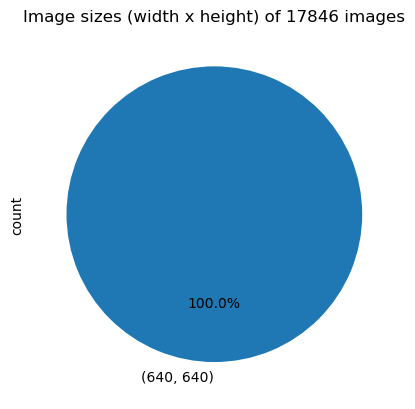

In [5]:
# Load images and check their size (image filename is {index}.png)
from PIL import Image
import os

def load_image(image_path):
    with Image.open(image_path) as img:
        return img


image_sizes = df.filename.map(lambda x: f'data/img/{x}')
image_sizes = image_sizes.map(lambda x: load_image(x).size)

# plot the image sizes in a pie chart
image_sizes.value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Image sizes (width x height) of {len(image_sizes)} images')
plt.show()

## **1.2 Duplicate images**
There is a big chance that the dataset contains some duplicates. We need to filter them out

In [6]:
# Get duplicate lat and long
df['lat_long'] = df['latitude'].astype(str) + df['longitude'].astype(str)

# Print the number of duplicates
print(f'Removing duplicates: {df.duplicated(subset=["lat_long"]).sum()} (out of {len(df)} samples)')

# Drop the duplicates and keep the first occurence
df = df.drop_duplicates(subset=['lat_long'], keep='first')

Number of duplicates: 2133


## **1.3 Filter out black images**
Sometimes the map was not yet loaded when scraping the images. To avoid confusion we will need to delete blacked out images

In [7]:
black_images = 0

# Load images and check if they are mostly black.
def is_black_image(image_path):
    with Image.open(image_path) as img:
        # Check if the image is fully black
        return img.getbbox() is None

# Remove black images from the dataframe
for i in df.index:
    if is_black_image(f'data/img/{df.loc[i].filename}'):
        black_images += 1
        df = df.drop(i)


print(f'Removed {black_images} black images out of {len(df)} images')

Removed 47 black images out of 15666 images


## **1.4 Image locations**
Lets check if all images are within the united states or in any of their territories

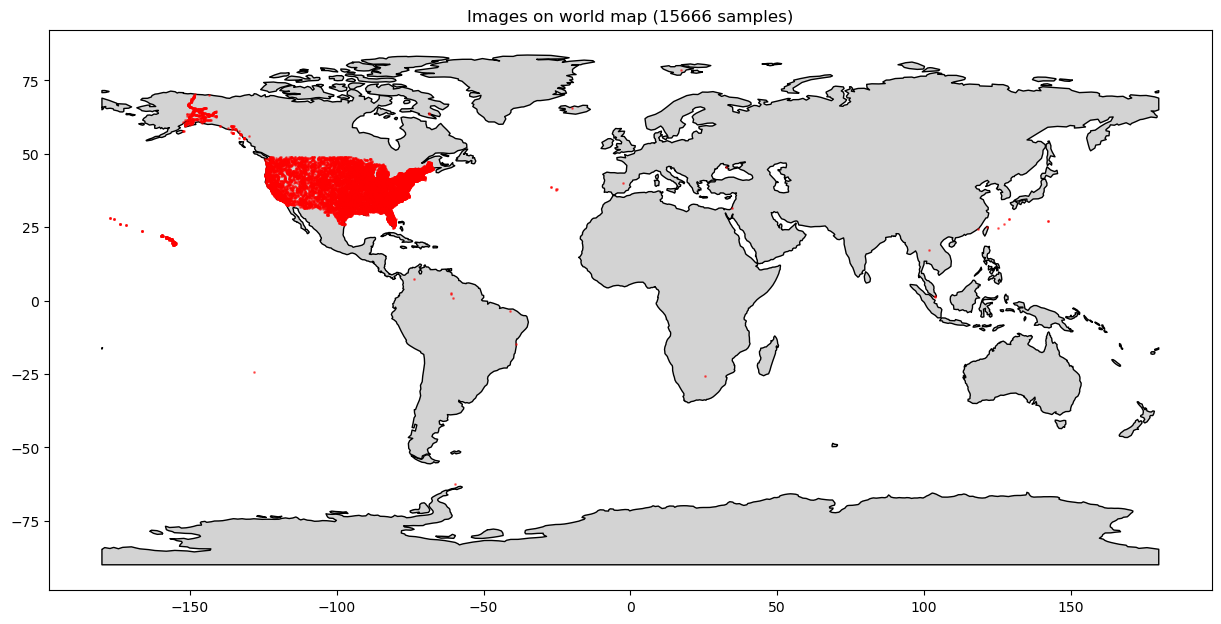

In [8]:
import geodatasets as gds
import geopandas as gpd

# Create a geodataframe from the dataframe
all_images_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

def plot_images_on_world_map(gdf):
    # Load the world map
    world = gpd.read_file(gds.get_path('naturalearth.land'))

    # Plot the world map
    world.plot(color='lightgrey', edgecolor='black', figsize=(15, 15))

    # Plot the image data on top of the world map
    gdf.plot(ax=plt.gca(), color='red', markersize=1, marker='o', alpha=0.5)

    plt.title(f'Images on world map ({len(gdf)} samples)')
    plt.show()

plot_images_on_world_map(all_images_gdf)

> You can see that there are some outliers in the data outside of the USA. These will need to be removed

## **1.5 Filter out images outside of the USA**
Lets use the state and territory data to filter out any images outside of the usa

In [ ]:
# Load the usa states shapefile
usa_states_shapes = gpd.read_file('data/usa_shapefile/tl_2023_us_state.shp')

# Filter out us territories and federal districts
# Territories: American Samoa (AS), Guam (GU), Northern Mariana Islands (MP), Puerto Rico (PR), Virgin Islands (VI)
# Federal district: District of Columbia (DC)
usa_states_shapes = usa_states_shapes[~usa_states_shapes['STUSPS'].isin(['AS', 'GU', 'MP', 'PR', 'VI', 'DC'])]

# Create a union of all U.S. states
usa_union = usa_states_shapes.geometry.unary_union

# Filter points that are within the U.S.
points_in_usa_gdf = all_images_gdf[all_images_gdf.within(usa_union)]

# Set CRS to the usa_states_shapes CRS (avoiding warning)
points_in_usa_gdf.crs = usa_states_shapes.crs

print(f'Found {len(points_in_usa_gdf)} points within the U.S. out of {len(all_images_gdf)}')

## **1.6 Classifying images**
Images can now be classified as all under the United states. However, for the model to perform well we will classify the usa based on its many states

In [9]:
# Use the geopandas sjoin function to join the image data with the U.S. states
usa_gdf = gpd.sjoin(usa_states_shapes, points_in_usa_gdf, how='inner')

print(usa_gdf.info())
usa_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 15627 entries, 0 to 55
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   REGION       15627 non-null  object  
 1   DIVISION     15627 non-null  object  
 2   STATEFP      15627 non-null  object  
 3   STATENS      15627 non-null  object  
 4   GEOID        15627 non-null  object  
 5   GEOIDFQ      15627 non-null  object  
 6   STUSPS       15627 non-null  object  
 7   NAME         15627 non-null  object  
 8   LSAD         15627 non-null  object  
 9   MTFCC        15627 non-null  object  
 10  FUNCSTAT     15627 non-null  object  
 11  ALAND        15627 non-null  int64   
 12  AWATER       15627 non-null  int64   
 13  INTPTLAT     15627 non-null  object  
 14  INTPTLON     15627 non-null  object  
 15  geometry     15627 non-null  geometry
 16  index_right  15627 non-null  int64   
 17  latitude     15627 non-null  float64 
 18  longitude    15627 non-nul

REGION DIVISION STATEFP   STATENS GEOID      GEOIDFQ STUSPS           NAME  \
0      3        5      54  01779805    54  0400000US54     WV  West Virginia   
0      3        5      54  01779805    54  0400000US54     WV  West Virginia   
0      3        5      54  01779805    54  0400000US54     WV  West Virginia   
0      3        5      54  01779805    54  0400000US54     WV  West Virginia   
0      3        5      54  01779805    54  0400000US54     WV  West Virginia   

  LSAD  MTFCC  ...        ALAND     AWATER     INTPTLAT      INTPTLON  \
0   00  G4000  ...  62266499712  489003081  +38.6472854  -080.6183274   
0   00  G4000  ...  62266499712  489003081  +38.6472854  -080.6183274   
0   00  G4000  ...  62266499712  489003081  +38.6472854  -080.6183274   
0   00  G4000  ...  62266499712  489003081  +38.6472854  -080.6183274   
0   00  G4000  ...  62266499712  489003081  +38.6472854  -080.6183274   

                                            geometry index_right   latitude  \
0  POLYGON ((-77.75438 39.33346, -77.75422 39.333...        2077  38.249588   
0  POLYGON ((-77.75438 39.33346, -77.75422 39.333...        4695  38.682491   
0  POLYGON ((-77.75438 39.33346, -77.75422 39.333...        4359  38.689789   
0  POLYGON ((-77.75438 39.33346, -77.75422 39.333...         255  38.707516   
0  POLYGON ((-77.75438 39.33346, -77.75422 39.333...       17722  38.828781   

   longitude   filename               lat_long  
0 -79.902061   2139.png  38.24958801-79.902061  
0 -80.006332   5019.png   38.6824913-80.006332  
0 -79.174202   4642.png  38.68978882-79.174202  
0 -79.466072    259.png  38.70751572-79.466072  
0 -79.872986  19615.png  38.82878113-79.872986  

[5 rows x 21 columns]

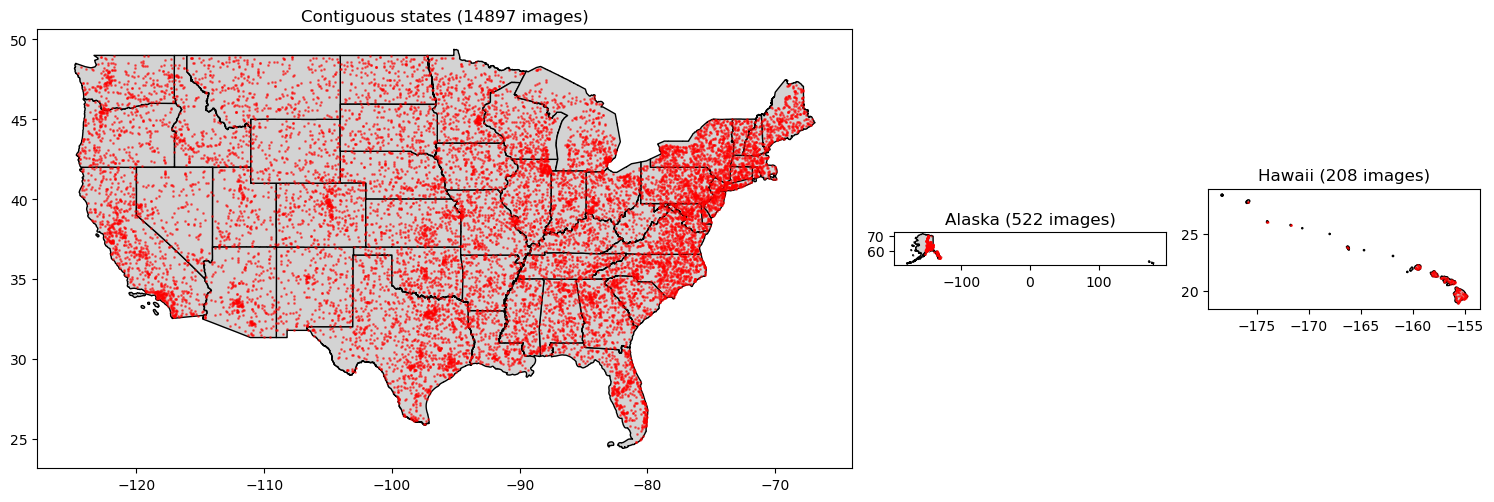

In [10]:
def plot_images_on_usa_map(full_gdf):
    # Filter them out from the mainland U.S.
    contiguous_states = usa_states_shapes[~usa_states_shapes['STUSPS'].isin(['AK', 'HI'])]

    # Split images into mainland and Alaska/Hawaii and create geodataframes
    mainland_images = full_gdf[~full_gdf['STUSPS'].isin(['AK', 'HI'])]
    ak_images = full_gdf[full_gdf['STUSPS'] == 'AK']
    hi_images = full_gdf[full_gdf['STUSPS'] == 'HI']

    # Create subplots: 1 for the mainland and 2 smaller ones for Alaska and Hawaii
    fig = plt.figure(figsize=(15, 10))
    grid = fig.add_gridspec(1, 3, width_ratios=[3, 1, 1])

    # Plot the mainland U.S.
    ax_main = fig.add_subplot(grid[0, 0])
    contiguous_states.plot(ax=ax_main, color='lightgrey', edgecolor='black')
    ax_main.set_title(f"Contiguous states ({len(mainland_images)} images)")

    # Alaska
    ax_ak = fig.add_subplot(grid[0, 1])
    usa_states_shapes[usa_states_shapes['STUSPS'] == 'AK'].plot(ax=ax_ak, color='lightgrey', edgecolor='black')
    ax_ak.set_title(f"Alaska ({len(ak_images)} images)")

    # Hawaii
    ax_hi = fig.add_subplot(grid[0, 2])
    usa_states_shapes[usa_states_shapes['STUSPS'] == 'HI'].plot(ax=ax_hi, color='lightgrey', edgecolor='black')
    ax_hi.set_title(f"Hawaii ({len(hi_images)} images)")


    # Plot the datapoints on their own maps
    mainland_gdf = gpd.GeoDataFrame(mainland_images, geometry=gpd.points_from_xy(mainland_images.longitude, mainland_images.latitude))
    mainland_gdf.plot(ax=ax_main, color='red', markersize=1, alpha=0.5, marker='o')

    ak_gdf = gpd.GeoDataFrame(ak_images, geometry=gpd.points_from_xy(ak_images.longitude, ak_images.latitude))
    ak_gdf.plot(ax=ax_ak, color='red', markersize=0.5, alpha=0.5, marker='o')

    hi_gdf = gpd.GeoDataFrame(hi_images, geometry=gpd.points_from_xy(hi_images.longitude, hi_images.latitude))
    hi_gdf.plot(ax=ax_hi, color='red', markersize=0.5, alpha=0.5, marker='o')

    # Remove axes for cleaner look
    plt.tight_layout()
    plt.show()


plot_images_on_usa_map(usa_gdf)

In [ ]:
# Plotting states with images
states = pd.read_csv('data/states.csv')
states_gdf = gpd.GeoDataFrame(states, geometry=gpd.points_from_xy(states.lon, states.lat))

plot_images_on_usa_map(states_gdf)

## **1.7 State image distribution**
Lets see if the images are evenly distributed over the states

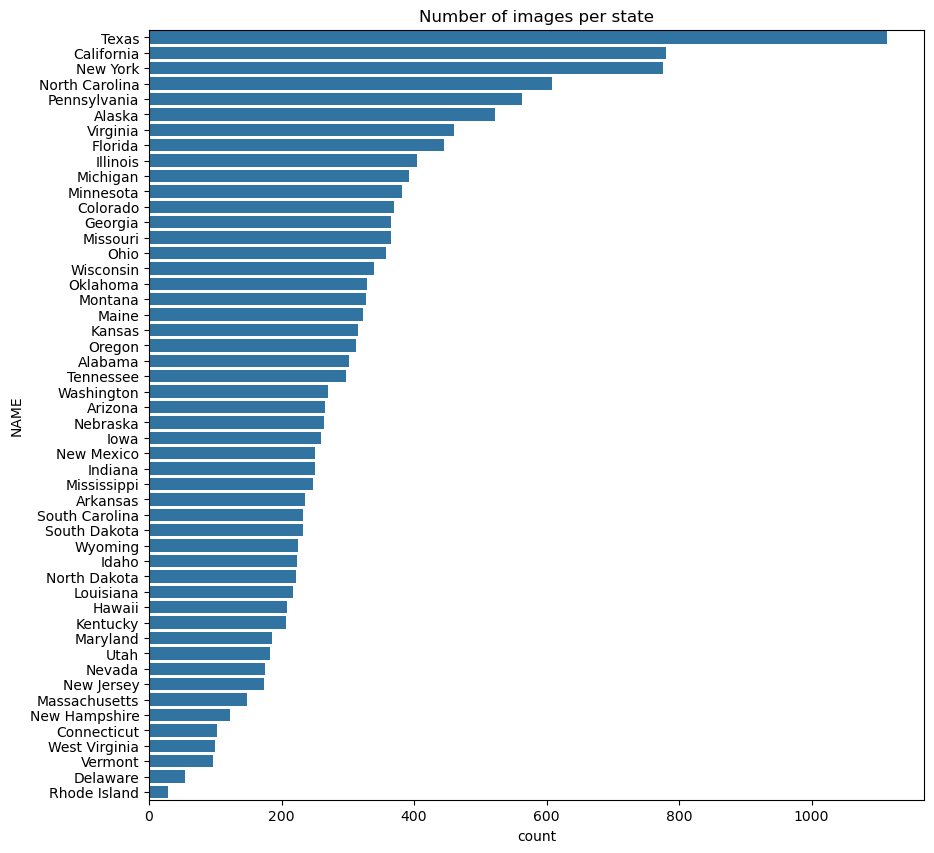

In [11]:
import seaborn as sns

# Plot the number of images per state (horizontal bar plot)
plt.figure(figsize=(10, 10))
sns.countplot(y='NAME', data=usa_gdf, order=usa_gdf['NAME'].value_counts().index)
plt.title('Number of images per state')
plt.show()

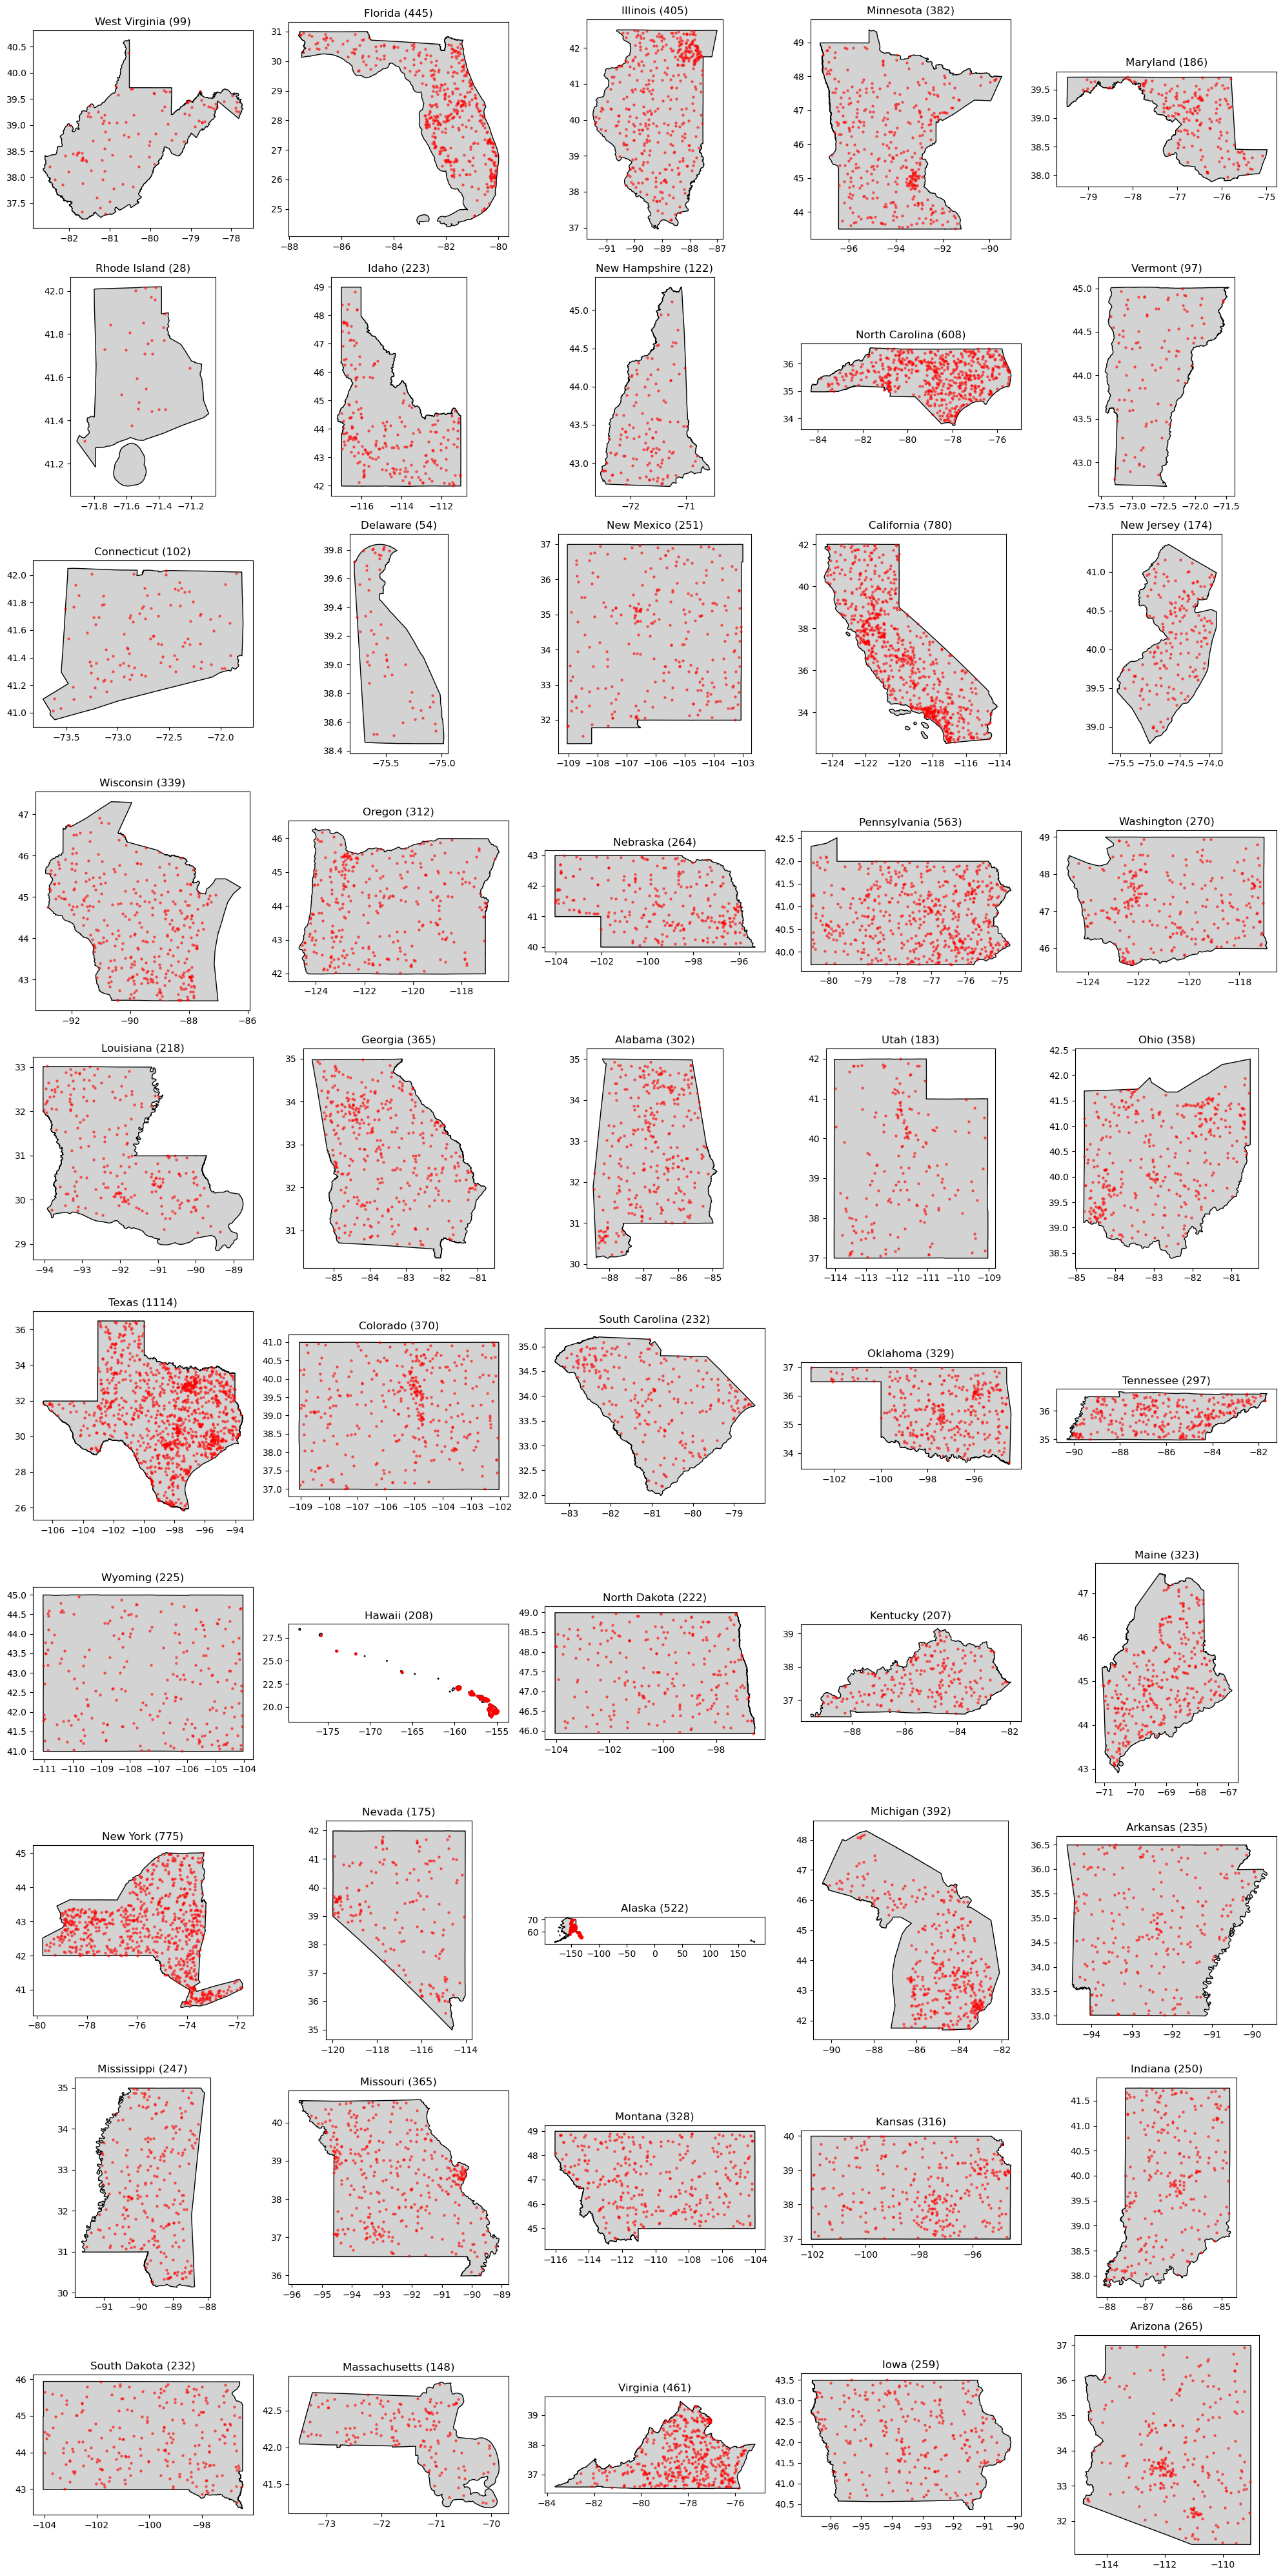

In [12]:
def plot_state_data_distribution(gdf, state_shapes):
    # Create a grid for 10 rows by 5 columns of plots
    fig, axs = plt.subplots(10, 5, figsize=(20, 40))

    # Get all state names
    state_abbrvs = gdf['STUSPS'].unique()

    # Iterate over the state names and plot the data distribution
    for i, state_abbrv in enumerate(state_abbrvs):
        state_data = gdf[gdf['STUSPS'] == state_abbrv]

        # Create a geodataframe with the state data points
        state_data_gdf = gpd.GeoDataFrame(state_data, geometry=gpd.points_from_xy(state_data.longitude, state_data.latitude))

        # Get the state shape
        state_shape = state_shapes[state_shapes['STUSPS'] == state_abbrv]

        # Plot the state shape on the axis
        state_shape.plot(ax=axs[i // 5, i % 5], color='lightgrey', edgecolor='black', figsize=(5,5))

        # Plot the state data on top of the state shape
        state_data_gdf.plot(ax=axs[i // 5, i % 5], color='red', markersize=5, alpha=0.5, marker='o')

        # Set the title of the subplot
        axs[i // 5, i % 5].set_title(f'{state_shape["NAME"].values[0]} ({len(state_data)})')

    plt.tight_layout()
    plt.show()

plot_state_data_distribution(usa_gdf, usa_states_shapes)

> We can see that each state is diversely represented

## **1.8 Image previews**
Lets preview some images to make sure they are of similar quality and of environment

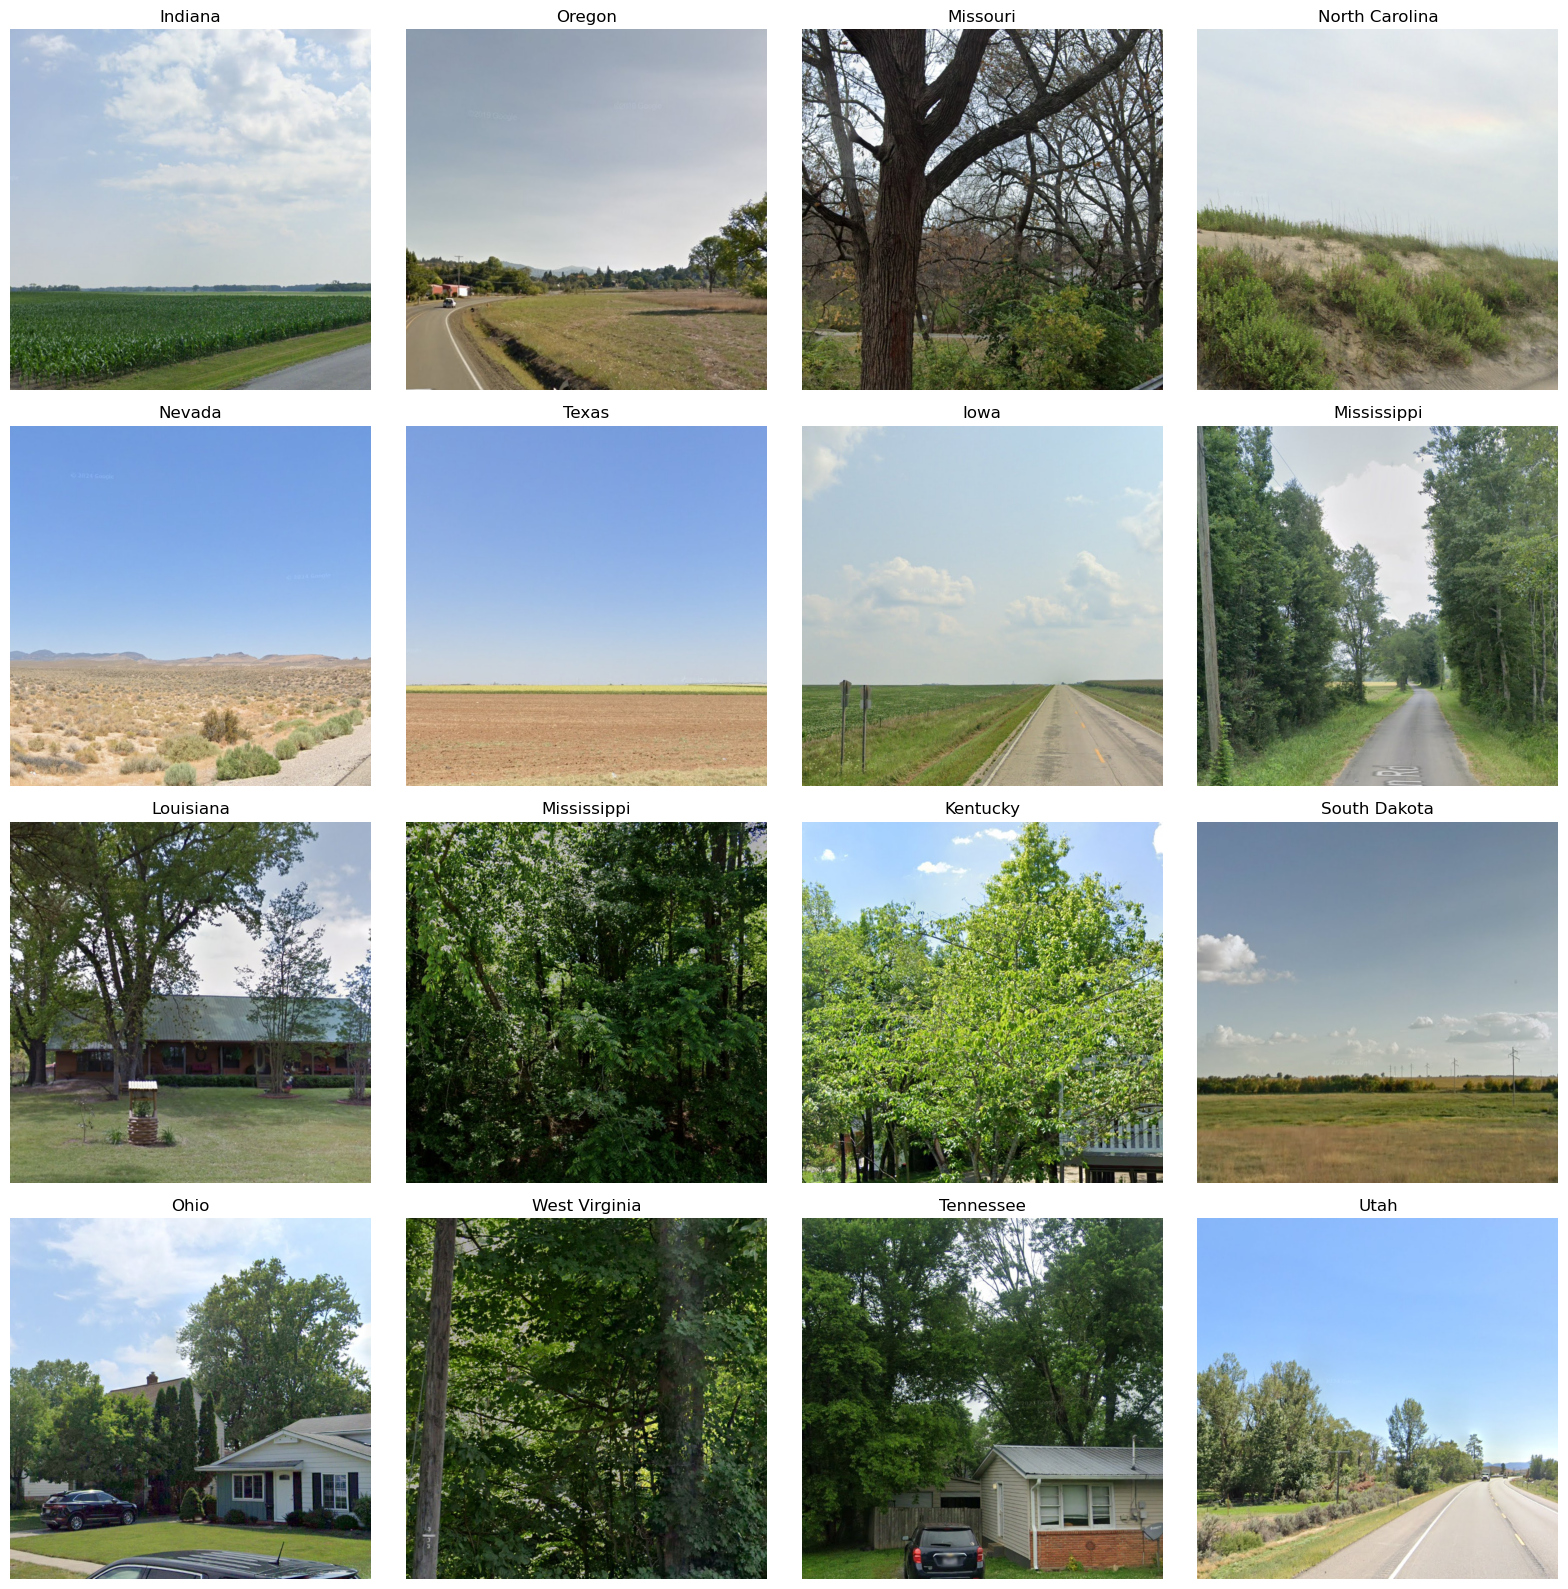

In [13]:
# Plot images on rows of 4
def plot_images(df, n_images=16):
    fig, axes = plt.subplots(n_images // 4, 4, figsize=(16, 16))
    axes = axes.flatten()
    for i, (_, row) in enumerate(df.iterrows()):
        img = Image.open(f'data/img/{row['filename']}')
        axes[i].imshow(img)
        axes[i].set_title(row['NAME'])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


# Get a random sample of images
plot_images(usa_gdf.sample(16), n_images=16)

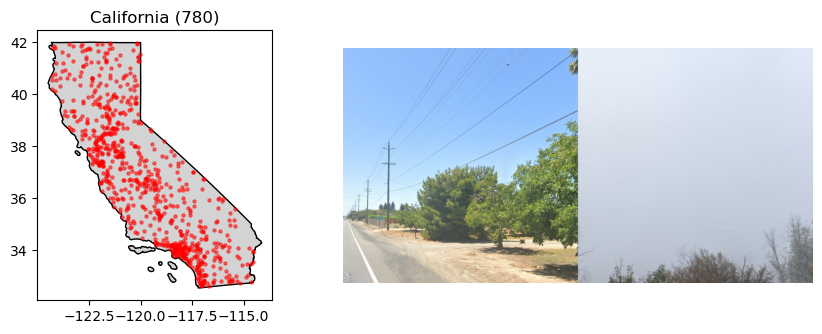

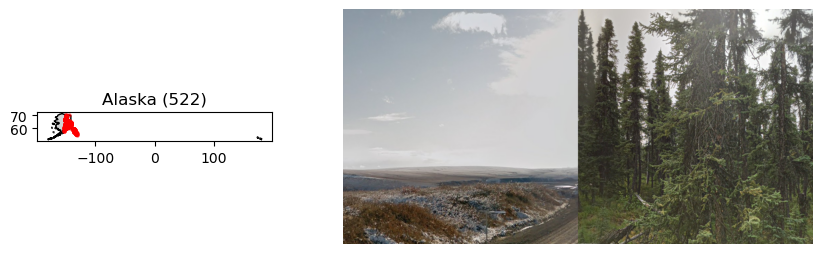

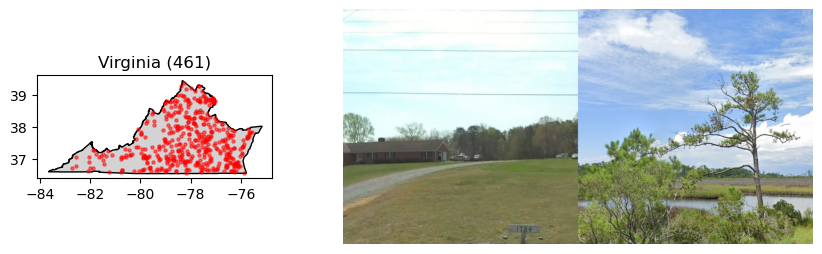

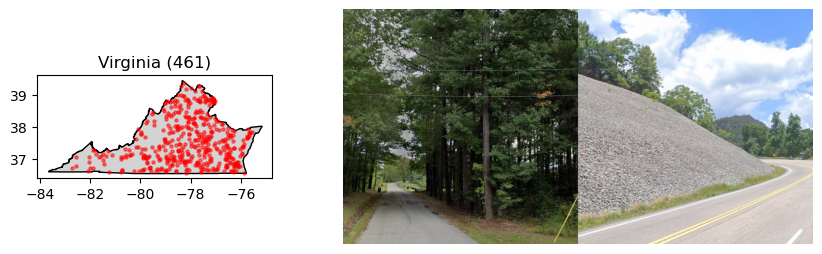

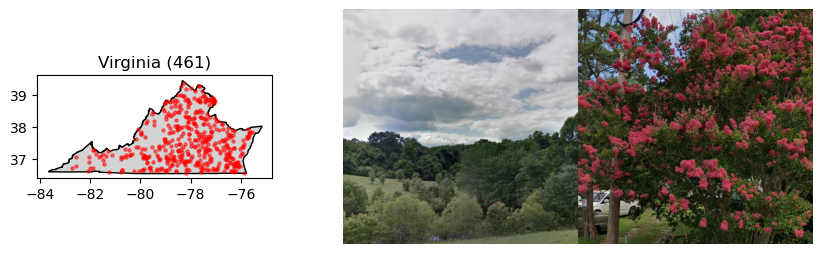

In [14]:
import numpy as np

def plot_preview_images_for_state(usa_gdf, state_name):
    # Get the state data
    state_data = usa_gdf[usa_gdf['NAME'] == state_name]

    # Get a random sample of 2 images
    random_state_images = state_data.sample(2)

    # Make a subplot with a map on the left and the images on the right (2 images per row)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [1, 2]})

    # Plot the state shape on the left
    state_shape = usa_states_shapes[usa_states_shapes['NAME'] == state_name]
    state_shape.plot(ax=ax1, color='lightgrey', edgecolor='black', figsize=(5,5))

    # Plot the state data on top of the state shape
    state_data_gdf = gpd.GeoDataFrame(state_data, geometry=gpd.points_from_xy(state_data.longitude, state_data.latitude))
    state_data_gdf.plot(ax=ax1, color='red', markersize=5, alpha=0.5, marker='o')

    # Set the title of the subplot
    ax1.set_title(f'{state_name} ({len(state_data)})')

    # Plot the images on the right
    ax2.imshow(np.hstack([np.array(Image.open(f'data/img/{row["filename"]}')) for _, row in random_state_images.iterrows()]))
    ax2.axis('off')


    plt.show()

for random_state in usa_gdf['NAME'].sample(5):
    plot_preview_images_for_state(usa_gdf, random_state)

## **1.9 Saving cleansed data**
Lets save the cleansed data to use when training the model later

In [21]:
import zipfile

# Saving the new data (without duplicates, only U.S. states, and categorical columns)
wanted_columns = ['NAME', 'STUSPS', 'latitude', 'longitude', 'filename']

# Header columns naming
new_dataframe = usa_gdf[wanted_columns]
new_dataframe.columns = ['state_name', 'state_abbr', 'latitude', 'longitude', 'filename']

# Create a zip file and save the new dataframe with all included images
with zipfile.ZipFile('data/dataset.zip', 'w') as z:
    # Save all images to the zip file
    for filename in new_dataframe['filename']:
        z.write(f'data/img/{filename}', f'img/{filename}')

    # Save the new dataframe to the zip file
    new_dataframe.to_csv('data/image_data_cleaned.csv', index=False)
    z.write('data/image_data_cleaned.csv', 'image_data.csv')

print(f'Cleaned dataset saved to data/dataset.zip ({new_dataframe.shape[0]} images)')

Cleaned dataset saved to data/dataset.zip (15627 images)
